In [2]:
# Run in python console
import nltk

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt


# Enable logging for gensim - optional
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#nltk.download('stopwords')
# nltk.download('punkt') 
# nltk.download('averaged_perceptron_tagger')

# NLTK Stop words
from nltk.corpus import stopwords

C:\Users\KYH\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
#불용단어 준비
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) #여기는 우리가 불용단어 추가하면 된다.

In [64]:
# Import Dataset
def to_table(filename):
    with open(filename, 'r') as apple:
        a = []
        for apps in apple.readlines():
            b = (apps.strip())
            b = b.strip('.,?!;-')
            a.append(b)
            line_list = []
            for line in a:
                line = line.strip('.,?!;-')
                line_list += line.split()
    return line_list

df = to_table('test_text(2).txt')
# print(df)

['FOR', 'the', 'most', 'wild,', 'yet', 'most', 'homely', 'narrative', 'which', 'I', 'am', 'about', 'to', 'pen,', 'I', 'neither', 'expect', 'nor', 'solicit', 'belief.', 'Mad', 'indeed', 'would', 'I', 'be', 'to', 'expect', 'it,', 'in', 'a', 'case', 'where', 'my', 'very', 'senses', 'reject', 'their', 'own', 'evidence.', 'Yet,', 'mad', 'am', 'I', 'not', '--', 'and', 'very', 'surely', 'do', 'I', 'not', 'dream.', 'But', 'to-morrow', 'I', 'die,', 'and', 'to-day', 'I', 'would', 'unburthen', 'my', 'soul.', 'My', 'immediate', 'purpose', 'is', 'to', 'place', 'before', 'the', 'world,', 'plainly,', 'succinctly,', 'and', 'without', 'comment,', 'a', 'series', 'of', 'mere', 'household', 'events.', 'In', 'their', 'consequences,', 'these', 'events', 'have', 'terrified', '--', 'have', 'tortured', '--', 'have', 'destroyed', 'me.', 'Yet', 'I', 'will', 'not', 'attempt', 'to', 'expound', 'them.', 'To', 'me,', 'they', 'have', 'presented', 'little', 'but', 'Horror', '--', 'to', 'many', 'they', 'will', 'seem', 

In [63]:
tmp = []
for i in df:
    i = i.strip('.,?!;-').lower()
    texts = nltk.word_tokenize(i)
    tmp += nltk.pos_tag(texts)

# print(tmp)

[('for', 'IN'), ('the', 'DT'), ('most', 'JJS'), ('wild', 'NN'), ('yet', 'RB'), ('most', 'JJS'), ('homely', 'RB'), ('narrative', 'JJ'), ('which', 'WDT'), ('i', 'NN'), ('am', 'VBP'), ('about', 'IN'), ('to', 'TO'), ('pen', 'VB'), ('i', 'NN'), ('neither', 'DT'), ('expect', 'VB'), ('nor', 'CC'), ('solicit', 'NN'), ('belief', 'NN'), ('mad', 'NN'), ('indeed', 'RB'), ('would', 'MD'), ('i', 'NN'), ('be', 'VB'), ('to', 'TO'), ('expect', 'VB'), ('it', 'PRP'), ('in', 'IN'), ('a', 'DT'), ('case', 'NN'), ('where', 'WRB'), ('my', 'PRP$'), ('very', 'RB'), ('senses', 'NNS'), ('reject', 'NN'), ('their', 'PRP$'), ('own', 'JJ'), ('evidence', 'NN'), ('yet', 'RB'), ('mad', 'NN'), ('am', 'VBP'), ('i', 'NN'), ('not', 'RB'), ('and', 'CC'), ('very', 'RB'), ('surely', 'RB'), ('do', 'VB'), ('i', 'NN'), ('not', 'RB'), ('dream', 'NN'), ('but', 'CC'), ('to-morrow', 'NN'), ('i', 'NN'), ('die', 'NN'), ('and', 'CC'), ('to-day', 'NN'), ('i', 'NN'), ('would', 'MD'), ('unburthen', 'NN'), ('my', 'PRP$'), ('soul', 'NN'), ('

In [67]:
# http://sens.tistory.com/454 참조, 형태소따라 나누기
def pos_extractor(parsed):

    noun_list = []
    adj_list = []
    verb_list = []
    nav_list = []
    adv_list = []

    for i in parsed:

        if i[1] in ['NN', 'NNS', 'NNP', 'NNPS']:
            noun_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] in ['JJ', 'JJR', 'JJS']:
            adj_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            verb_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] == ['RB', 'RBR', 'RBS']:
            adv_list.append(i[0])
            nav_list.append(i[0])

        else:
            pass

    return [nav_list, noun_list, adj_list,
            verb_list]  

# print(pos_extractor(tmp))

data_words = list(pos_extractor(tmp)[0])


[['most', 'wild', 'most', 'narrative', 'i', 'am', 'pen', 'i', 'expect', 'solicit', 'belief', 'mad', 'i', 'be', 'expect', 'case', 'senses', 'reject', 'own', 'evidence', 'mad', 'am', 'i', 'do', 'i', 'dream', 'to-morrow', 'i', 'die', 'to-day', 'i', 'unburthen', 'soul', 'immediate', 'purpose', 'is', 'place', 'world', 'comment', 'series', 'household', 'events', 'consequences', 'events', 'have', 'terrified', 'have', 'tortured', 'have', 'destroyed', 'i', 'attempt', 'expound', 'have', 'presented', 'little', 'horror', 'many', 'seem', 'terrible', 'barroques', 'hereafter', 'intellect', 'be', 'found', 'reduce', 'phantasm', 'common-place', 'intellect', 'calm', 'logical', 'excitable', 'own', 'perceive', 'circumstances', 'i', 'detail', 'awe', 'nothing', 'ordinary', 'succession', 'natural', 'causes', 'effects', 'infancy', 'i', 'was', 'noted', 'docility', 'humanity', 'disposition', 'tenderness', 'heart', 'was', 'conspicuous', 'make', 'jest', 'companions', 'i', 'was', 'fond', 'animals', 'was', 'indulged

In [77]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# print(data_words)
# print(trigram_mod[bigram_mod[data_words]])

['most', 'wild', 'most', 'narrative', 'i', 'am', 'pen', 'i', 'expect', 'solicit', 'belief', 'mad', 'i', 'be', 'expect', 'case', 'senses', 'reject', 'own', 'evidence', 'mad', 'am', 'i', 'do', 'i', 'dream', 'to-morrow', 'i', 'die', 'to-day', 'i', 'unburthen', 'soul', 'immediate', 'purpose', 'is', 'place', 'world', 'comment', 'series', 'household', 'events', 'consequences', 'events', 'have', 'terrified', 'have', 'tortured', 'have', 'destroyed', 'i', 'attempt', 'expound', 'have', 'presented', 'little', 'horror', 'many', 'seem', 'terrible', 'barroques', 'hereafter', 'intellect', 'be', 'found', 'reduce', 'phantasm', 'common-place', 'intellect', 'calm', 'logical', 'excitable', 'own', 'perceive', 'circumstances', 'i', 'detail', 'awe', 'nothing', 'ordinary', 'succession', 'natural', 'causes', 'effects', 'infancy', 'i', 'was', 'noted', 'docility', 'humanity', 'disposition', 'tenderness', 'heart', 'was', 'conspicuous', 'make', 'jest', 'companions', 'i', 'was', 'fond', 'animals', 'was', 'indulged'

['most', 'wild', 'most', 'narrative', 'i', 'am', 'pen', 'i', 'expect', 'solicit', 'belief', 'mad', 'i', 'be', 'expect', 'case', 'senses', 'reject', 'own', 'evidence', 'mad', 'am', 'i', 'do', 'i', 'dream', 'to-morrow', 'i', 'die', 'to-day', 'i', 'unburthen', 'soul', 'immediate', 'purpose', 'is', 'place', 'world', 'comment', 'series', 'household', 'events', 'consequences', 'events', 'have', 'terrified', 'have', 'tortured', 'have', 'destroyed', 'i', 'attempt', 'expound', 'have', 'presented', 'little', 'horror', 'many', 'seem', 'terrible', 'barroques', 'hereafter', 'intellect', 'be', 'found', 'reduce', 'phantasm', 'common-place', 'intellect', 'calm', 'logical', 'excitable', 'own', 'perceive', 'circumstances', 'i', 'detail', 'awe', 'nothing', 'ordinary', 'succession', 'natural', 'causes', 'effects', 'infancy', 'i', 'was', 'noted', 'docility', 'humanity', 'disposition', 'tenderness', 'heart', 'was', 'conspicuous', 'make', 'jest', 'companions', 'i', 'was', 'fond', 'animals', 'was', 'indulged'

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [10]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en (아나콘다 관리자권한에서 실행)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [11]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized)

[[], ['wild'], [], ['narrative'], [], [], ['pen'], [], ['expect'], ['solicit'], ['belief'], ['mad'], [], [], ['expect'], ['case'], ['sens'], ['reject'], [], ['evidence'], ['mad'], [], [], [], [], ['dream'], ['morrow'], [], ['die'], ['day'], [], ['unburthen'], ['soul'], ['immediate'], ['purpose'], [], ['place'], ['world'], ['comment'], ['series'], ['household'], ['event'], ['consequence'], ['event'], [], ['terrify'], [], ['torture'], [], ['destroy'], [], ['attempt'], ['expound'], [], ['present'], ['little'], ['horror'], ['many'], ['seem'], ['terrible'], ['barroque'], ['hereafter'], ['intellect'], [], ['find'], ['reduce'], ['phantasm'], ['common', 'place'], ['intellect'], ['calm'], ['logical'], ['excitable'], [], ['perceive'], ['circumstance'], [], ['detail'], ['awe'], ['nothing'], ['ordinary'], ['succession'], ['natural'], ['cause'], ['effect'], ['infancy'], [], [], ['note'], ['docility'], ['humanity'], ['disposition'], ['tenderness'], ['heart'], [], ['conspicuous'], ['make'], ['jest'],

In [86]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# print(id2word)

# Create Corpus
texts = data_lemmatized
for i in texts:
    try:
        i == [] or ['\n']
        texts.remove(i)
    except IndexError:
        pass

list_a = []
for i in texts:
    try:
        list_a.append(i[0])
    except IndexError:
        pass

# Term Document Frequency
corpus = [id2word.doc2bow(list_a) for text in texts]
# print(corpus)
# print(corpus[2]) # 일부가 출력되었음
 
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

Dictionary(91 unique tokens: ['unburthen', 'attempt', 'natural', 'growth', 'opportunity']...)


[[(1, 1), (3, 1), (5, 1), (7, 1), (9, 1), (11, 1), (13, 1), (15, 1), (17, 1), (19, 1), (21, 1), (23, 1), (25, 1), (27, 1), (29, 1), (31, 1), (33, 1), (35, 1), (36, 1), (38, 1), (40, 1), (42, 1), (44, 1), (46, 2), (48, 1), (50, 1), (52, 1), (53, 1), (55, 1), (57, 1), (59, 1), (60, 1), (62, 1), (64, 1), (66, 1), (69, 1), (71, 1), (73, 1), (75, 1), (79, 1), (81, 1), (82, 1), (84, 1), (85, 1), (86, 1), (88, 1), (90, 1)], [(1, 1), (3, 1), (5, 1), (7, 1), (9, 1), (11, 1), (13, 1), (15, 1), (17, 1), (19, 1), (21, 1), (23, 1), (25, 1), (27, 1), (29, 1), (31, 1), (33, 1), (35, 1), (36, 1), (38, 1), (40, 1), (42, 1), (44, 1), (46, 2), (48, 1), (50, 1), (52, 1), (53, 1), (55, 1), (57, 1), (59, 1), (60, 1), (62, 1), (64, 1), (66, 1), (69, 1), (71, 1), (73, 1), (75, 1), (79, 1), (81, 1), (82, 1), (84, 1), (85, 1), (86, 1), (88, 1), (90, 1)], [(1, 1), (3, 1), (5, 1), (7, 1), (9, 1), (11, 1), (13, 1), (15, 1), (17, 1), (19, 1), (21, 1), (23, 1), (25, 1), (27, 1), (29, 1), (31, 1), (33, 1), (35, 1), (

[[('attempt', 1),
  ('growth', 1),
  ('intelligence', 1),
  ('change', 1),
  ('malevolence', 1),
  ('expect', 1),
  ('inclination', 1),
  ('blaze', 1),
  ('collect', 1),
  ('neck', 1),
  ('carcass', 1),
  ('remorse', 1),
  ('top', 1),
  ('white', 1),
  ('great', 1),
  ('odious', 1),
  ('dress', 1),
  ('attention', 1),
  ('mark', 1),
  ('shudder', 1),
  ('start', 1),
  ('sole', 1),
  ('cat', 1),
  ('descended', 2),
  ('cut', 1),
  ('displace', 1),
  ('hair', 1),
  ('labor', 1),
  ('appear', 1),
  ('impossible', 1),
  ('night', 1),
  ('introduction', 1),
  ('breathe', 1),
  ('make', 1),
  ('feel', 1),
  ('cellar', 1),
  ('step', 1),
  ('allay', 1),
  ('put', 1),
  ('sob', 1),
  ('demon', 1),
  ('thought', 1),
  ('arm', 1),
  ('wall', 1),
  ('stand', 1),
  ('sit', 1),
  ('monster', 1)]]

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=20,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto',
per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"wall" + 0.009*"day" + 0.009*"beast" + 0.008*"house" + '
  '0.008*"plaster" + 0.007*"frequent" + 0.007*"length" + 0.006*"go" + '
  '0.006*"animal" + 0.006*"pluto"'),
 (1,
  '0.013*"house" + 0.012*"wall" + 0.009*"day" + 0.008*"night" + 0.008*"animal" '
  '+ 0.007*"length" + 0.007*"beast" + 0.007*"go" + 0.007*"leave" + '
  '0.006*"destroy"'),
 (2,
  '0.012*"wall" + 0.011*"house" + 0.009*"day" + 0.008*"length" + '
  '0.008*"animal" + 0.008*"night" + 0.008*"go" + 0.007*"reason" + '
  '0.007*"beast" + 0.007*"minute"'),
 (3,
  '0.012*"wall" + 0.009*"beast" + 0.009*"day" + 0.009*"house" + 0.008*"night" '
  '+ 0.008*"animal" + 0.008*"little" + 0.007*"length" + 0.007*"go" + '
  '0.007*"make"'),
 (4,
  '0.015*"wall" + 0.010*"house" + 0.010*"beast" + 0.009*"length" + 0.008*"day" '
  '+ 0.008*"animal" + 0.008*"reason" + 0.007*"night" + 0.006*"go" + '
  '0.006*"hand"'),
 (5,
  '0.013*"wall" + 0.010*"house" + 0.010*"beast" + 0.008*"animal" + 0.007*"go" '
  '+ 0.007*"minute" + 0.007*"le

In [15]:
# Compute Perplexity(모델 난이도)
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
 
# Compute Coherence Score(일관성 점수)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.177489118961218

Coherence Score:  0.8646799430899037


In [16]:
# Visualize the topics(대화형차트) - 토픽과 키워드 검사
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
3      5.835052        1       1 -0.000758  0.000796
1      5.758918        1       2  0.000167 -0.000321
5      5.673723        1       3  0.001343  0.001556
4      5.595981        1       4 -0.001138  0.000990
8      5.521080        1       5  0.000554 -0.002115
18     5.441399        1       6  0.000879 -0.000290
2      5.401002        1       7 -0.000090  0.001926
17     5.342438        1       8  0.000128  0.001776
15     5.331415        1       9  0.000711 -0.000596
11     5.236502        1      10 -0.000495 -0.000859
10     5.200923        1      11  0.000588 -0.002198
13     5.050291        1      12 -0.000307  0.000322
14     4.769084        1      13 -0.000784 -0.000698
6      4.743687        1      14 -0.001165 -0.004161
7      4.481485        1      15  0.001180 -0.002356
19     4.477275        1      16 -0.002981  0.004039
9      4.281907        1      17  0.004401  0.000212
12     4.219674        1      18  0.003065  0.003717
0      3.820384        1      19  0.000838 -0.001593
16     3.817778        1      20 -0.006135 -0.000146, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
156   Default  4730.000000       reason  4730.000000  30.0000  30.0000
393   Default  9459.000000         wall  9459.000000  29.0000  29.0000
14    Default  5676.000000          day  5676.000000  28.0000  28.0000
69    Default  5675.000000       animal  5675.000000  27.0000  27.0000
257   Default  5675.000000        beast  5675.000000  26.0000  26.0000
108   Default  3784.000000     frequent  3784.000000  25.0000  25.0000
138   Default  2838.000000        black  2838.000000  24.0000  24.0000
159   Default  3784.000000        pluto  3784.000000  23.0000  23.0000
414   Default  3784.000000       minute  3784.000000  22.0000  22.0000
165   Default  6621.000000        house  6621.000000  21.0000  21.0000
402   Default  3784.000000      plaster  3784.000000  20.0000  20.0000
208   Default  3784.000000         come  3784.000000  19.0000  19.0000
367   Default  2838.000000        whole  2838.000000  18.0000  18.0000
32    Default  3784.000000       little  3784.000000  17.0000  17.0000
239   Default  1892.000000       longer  1892.000000  16.0000  16.0000
33    Default  3784.000000       horror  3784.000000  15.0000  15.0000
285   Default  3784.000000         deed  3784.000000  14.0000  14.0000
468   Default  1892.000000         look  1892.000000  13.0000  13.0000
40    Default  2838.000000         find  2838.000000  12.0000  12.0000
636   Default  1892.000000      thought  1892.000000  11.0000  11.0000
81    Default  3784.000000    character  3784.000000  10.0000  10.0000
386   Default  2838.000000         fact  2838.000000   9.0000   9.0000
303   Default  2838.000000         give  2838.000000   8.0000   8.0000
28    Default  3784.000000      destroy  3784.000000   7.0000   7.0000
302   Default  2838.000000     creature  2838.000000   6.0000   6.0000
236   Default  1892.000000        demon  1892.000000   5.0000   5.0000
354   Default  2838.000000     possible  2838.000000   4.0000   4.0000
233   Default  3784.000000         hand  3784.000000   3.0000   3.0000
192   Default  4729.000000       length  4729.000000   2.0000   2.0000
363   Default  3784.000000         fire  3784.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
303   Topic20   145.286224         give  2838.449463   0.2932  -5.2211
208   Topic20   189.046097         come  3784.239990   0.2689  -4.9578
69    Topic20   279.093994       animal  5675.935547   0.2531  -4.5683
354   Topic20   141.610611     possible  2838.479736   0.2676  -5.2468
257   Topic20   268.808289        beast  5675.891602   0.2155  -4.6058
393   Topic20   426.712067         wall  9459.263672   0.1669  -4.1437
192   Topic20   216.36

In [25]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

[(16,
  [('wall', 0.015863571),
   ('animal', 0.0103756795),
   ('beast', 0.009993294),
   ('day', 0.008844533),
   ('house', 0.008187886),
   ('length', 0.008043507),
   ('reason', 0.0071598534),
   ('come', 0.0070280326),
   ('go', 0.006521989),
   ('character', 0.0064299614)]),
 (0,
  [('wall', 0.014334574),
   ('day', 0.009163644),
   ('beast', 0.00870448),
   ('house', 0.008245798),
   ('plaster', 0.00800458),
   ('frequent', 0.007403196),
   ('length', 0.006889584),
   ('go', 0.0064975847),
   ('animal', 0.0064933146),
   ('pluto', 0.0064132344)]),
 (12,
  [('wall', 0.0131567195),
   ('reason', 0.0102664465),
   ('house', 0.009996086),
   ('day', 0.008808566),
   ('night', 0.008629549),
   ('animal', 0.008295944),
   ('beast', 0.008259513),
   ('fire', 0.0073128324),
   ('deed', 0.006673529),
   ('frequent', 0.0065686195)]),
 (9,
  [('wall', 0.014392052),
   ('day', 0.01028589),
   ('house', 0.00903427),
   ('go', 0.008309213),
   ('night', 0.008214343),
   ('beast', 0.006822708)

In [32]:
# k의 수(최적의 토픽 수) 를 찾아보기 
#밑의 함수는 여러 LDA 모델을 교육하고 모델 및 해당하는 일관성 점수를 알려준다.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
 
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
 
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics,random_state=100,
                                              update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
 
    return model_list, coherence_values

In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

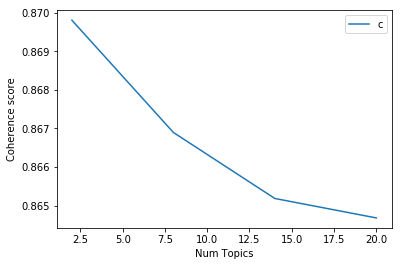

In [34]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores 가장 일관성 높은 모델 선택
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.8698
Num Topics = 8  has Coherence Value of 0.8669
Num Topics = 14  has Coherence Value of 0.8652
Num Topics = 20  has Coherence Value of 0.8647
Num Topics = 26  has Coherence Value of nan
Num Topics = 32  has Coherence Value of nan
Num Topics = 38  has Coherence Value of nan


In [61]:
# Select the model and print the topics
optimal_model = model_list[0] #여긴 경우에 따라 고치기
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.014*"wall" + 0.009*"beast" + 0.008*"day" + 0.007*"animal" + 0.007*"house" '
  '+ 0.007*"night" + 0.007*"minute" + 0.007*"reason" + 0.006*"plaster" + '
  '0.006*"length"'),
 (1,
  '0.013*"wall" + 0.012*"house" + 0.009*"night" + 0.009*"animal" + 0.008*"day" '
  '+ 0.008*"beast" + 0.007*"go" + 0.007*"length" + 0.007*"reason" + '
  '0.006*"cat"')]
